In [2]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

KeyboardInterrupt: ignored

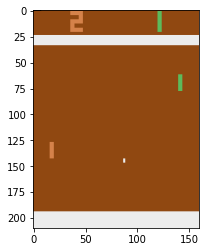

In [ ]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()


class PGAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99
        self.learning_rate = 0.001
        self.states = []
        self.gradients = []
        self.rewards = []
        self.probs = []
        self.model = self._build_model()
        self.model.summary()

    def _build_model(self):
        model = Sequential()
        model.add(Reshape((1, 80, 80), input_shape=(self.state_size,)))
        model.add(Convolution2D(32, 6, 6, subsample=(3, 3), border_mode='same',
                                activation='relu', init='he_uniform'))
        model.add(Flatten())
        model.add(Dense(64, activation='relu', init='he_uniform'))
        model.add(Dense(32, activation='relu', init='he_uniform'))
        model.add(Dense(self.action_size, activation='softmax'))
        opt = Adam(lr=self.learning_rate)
        model.compile(loss='categorical_crossentropy', optimizer=opt)
        return model

    def memorize(self, state, action, prob, reward):
        y = np.zeros([self.action_size])
        y[action] = 1
        self.gradients.append(np.array(y).astype('float32') - prob)
        self.states.append(state)
        self.rewards.append(reward)

    def act(self, state):
        state = state.reshape([1, state.shape[0]])
        aprob = self.model.predict(state, batch_size=1).flatten()
        self.probs.append(aprob)
        prob = aprob / np.sum(aprob)
        action = np.random.choice(self.action_size, 1, p=prob)[0]
        return action, prob

    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, rewards.size)):
            if rewards[t] != 0:
                running_add = 0
            running_add = running_add * self.gamma + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    def train(self):
        gradients = np.vstack(self.gradients)
        rewards = np.vstack(self.rewards)
        rewards = self.discount_rewards(rewards)
        reward = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
        gradients *= rewards
        X = np.squeeze(np.vstack([self.states]))
        Y = self.probs + self.learning_rate * np.squeeze(np.vstack([gradients]))
        self.model.train_on_batch(X, Y)
        self.states, self.probs, self.gradients, self.rewards = [], [], [], []

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

def preprocess(I):
    I = I[35:195]
    I = I[::2, ::2, 0]
    I[I == 144] = 0
    I[I == 109] = 0
    I[I != 0] = 1
    return I.astype(np.float).ravel()

if __name__ == "__main__":
    env = gym.make("Pong-v0")
    env.reset()
    prev_screen = env.render(mode='rgb_array')
    plt.imshow(prev_screen)

    state = env.reset()
    prev_x = None
    score = 0
    episode = 0

    state_size = 80 * 80
    action_size = env.action_space.n
    agent = PGAgent(state_size, action_size)
    #agent.load('G:\\pong.h5')
    while True:
        screen = env.render(mode='rgb_array')

        cur_x = preprocess(state)
        x = cur_x - prev_x if prev_x is not None else np.zeros(state_size)
        prev_x = cur_x

        action, prob = agent.act(x)
        state, reward, done, info = env.step(action)
        score += reward
        agent.memorize(x, action, prob, reward)
        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        if done:
            episode += 1
            agent.train()
            print('Episode: %d - Score: %f.' % (episode, score))
            score = 0
            state = env.reset()
            prev_x = None
            #if episode > 1 and episode % 10 == 0:
             #   agent.save('G:\\pong.h5')

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 317kB 2.8MB/s 


In [ ]:
%load_ext tensorboard
from datetime import datetime

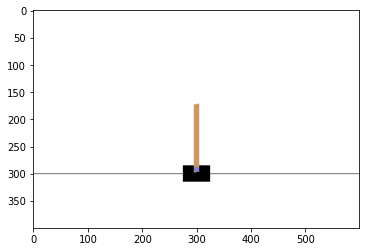

In [ ]:
#Policy Gradient for CartPole


import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

class PGAgent:
  def __init__(self,state_size,action_size):
    self.state_size=state_size
    self.action_size=action_size
    self.gamma=0.99
    self.learning_rate=0.001
    self.states=[]
    self.rewards=[]
    self.labels=[]
    self.prob=[]
    self.model=self.build_model()
    self.model.summary()
  
  def build_model(self):
    logdir= "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=keras.callbacks.TensorBoard(log_dir=logdir)

    model=Sequential()
    model.add(Dense(64,input_dim=self.state_size,activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Dense(64,activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Dense(self.action_size,activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=self.learning_rate),loss='categorical_crossentropy')
    return model

  def memory(self,state,action,prob,reward):
    y=np.zeros([self.action_size])
    y[action]=1
    self.labels.append(np.array(y).astype('float32'))
    self.states.append(state)
    self.rewards.append(reward)

  def act(self,state):
    state=state.reshape([1,state.shape[0]])
    probs=self.model.predict(state,batch_size=1).flatten()
    self.prob.append(probs)
    action=np.random.choice(self.action_size,1,p=probs)[0]
    return action,probs

  def discount_rewards(self, rewards):
    discounted_rewards = np.zeros_like(rewards)
    running_sum = 0
    for t in reversed(range(len(rewards))):
        if rewards[t] != 0:
            running_add = 0
        running_add = running_add * self.gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards


  def train(self):
    labels=np.vstack(self.labels)
    rewards=np.vstack(self.rewards)
    rewards=self.discount_rewards(rewards)
    rewards=(rewards-np.mean(rewards))/np.std(rewards)
    labels*=-rewards
    x=np.squeeze(np.vstack([self.states]))
    y=np.squeeze(np.vstack([self.labels]))
    self.model.train_on_batch(x,y)
    self.states,self.probs,self.labels,self.rewards=[],[],[],[]

  def load_model(self,name):
    self.model.load_weights(name)
  
  def save_model(self,name):
    self.model.save_weights(name)

if __name__=="__main__":
  env=gym.make('CartPole-v0')
  
  state=env.reset()
  
  score=0
  episode=0
  state_size=env.observation_space.shape[0]
  action_size=env.action_space.n
  agent=PGAgent(state_size,action_size)
  j=0
  while j is not 2000:
    screen = env.render(mode='rgb_array')
    action,prob=agent.act(state)
    state_1,reward,done,_=env.step(action)
    score+=reward
    agent.memory(state,action,prob,reward)
    state=state_1
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
      j+=1
      agent.rewards[-1]=score
      agent.train()
      print("Episode: %d - Score: %f."%(j,score))
      score=0.0
      state=env.reset()

    env.close()
      

KeyboardInterrupt: ignored

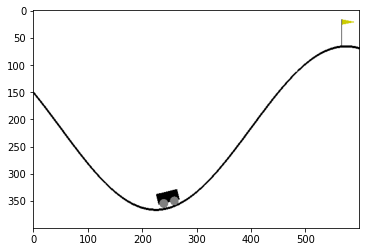

In [3]:
#Policy Gradient for CartPole


import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

class PGAgent:
  def __init__(self,state_size,action_size):
    self.state_size=state_size
    self.action_size=action_size
    self.gamma=0.99
    self.learning_rate=0.001
    self.states=[]
    self.rewards=[]
    self.labels=[]
    self.prob=[]
    self.model=self.build_model()
    self.model.summary()
  
  def build_model(self):
    logdir= "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=keras.callbacks.TensorBoard(log_dir=logdir)

    model=Sequential()
    model.add(Dense(64,input_dim=self.state_size,activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Dense(64,activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Dense(self.action_size,activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=self.learning_rate),loss='categorical_crossentropy')
    return model

  def memory(self,state,action,prob,reward):
    y=np.zeros([self.action_size])
    y[action]=1
    self.labels.append(np.array(y).astype('float32'))
    self.states.append(state)
    self.rewards.append(reward)

  def act(self,state):
    state=state.reshape([1,state.shape[0]])
    probs=self.model.predict(state,batch_size=1).flatten()
    self.prob.append(probs)
    action=np.random.choice(self.action_size,1,p=probs)[0]
    return action,probs

  def discount_rewards(self, rewards):
    discounted_rewards = np.zeros_like(rewards)
    running_sum = 0
    for t in reversed(range(len(rewards))):
        if rewards[t] != 0:
            running_add = 0
        running_add = running_add * self.gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards


  def train(self):
    labels=np.vstack(self.labels)
    rewards=np.vstack(self.rewards)
    rewards=self.discount_rewards(rewards)
    rewards=(rewards-np.mean(rewards))/np.std(rewards)
    labels*=-rewards
    x=np.squeeze(np.vstack([self.states]))
    y=np.squeeze(np.vstack([self.labels]))
    self.model.train_on_batch(x,y)
    self.states,self.probs,self.labels,self.rewards=[],[],[],[]

  def load_model(self,name):
    self.model.load_weights(name)
  
  def save_model(self,name):
    self.model.save_weights(name)

if __name__=="__main__":
  env=gym.make('MountainCar-v0')
  
  state=env.reset()
  
  score=0
  episode=0
  state_size=env.observation_space.shape[0]
  action_size=env.action_space.n
  agent=PGAgent(state_size,action_size)
  j=0
  while j is not 2000:
    screen = env.render(mode='rgb_array')
    action,prob=agent.act(state)
    state_1,reward,done,_=env.step(action)
    score+=reward
    agent.memory(state,action,prob,reward)
    state=state_1
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
      j+=1
      agent.rewards[-1]=score
      agent.train()
      print("Episode: %d - Score: %f."%(j,score))
      score=0.0
      state=env.reset()

    env.close()
      